<a href="https://colab.research.google.com/github/taylor-rao/MusicComposition/blob/master/PitchShiftV5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip install pydub

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from IPython.display import Audio
from scipy.io import wavfile
from numpy.matlib import repmat
import numpy, scipy.optimize
from pydub import AudioSegment
import os
#import pitch

In [0]:
def monotize(stereo):
  rel = np.zeros(len(stereo))
  for i in range(len(stereo)):
    rel[i] = stereo[i][1]
  return rel

In [0]:
fiile = wavfile.read('/content/476647__ffmmendoza90__hello-man.wav')
player = monotize(fiile[1])

In [25]:
#This shows the framerate.
fiile[0]

44100

If you run these cells in a notebook setting the original clip should play here.

In [26]:
Audio(player, rate = 44100 )

This is what the overrall signal looks like. To really get a better idea of what is going on, we are going to have to zoom in more.

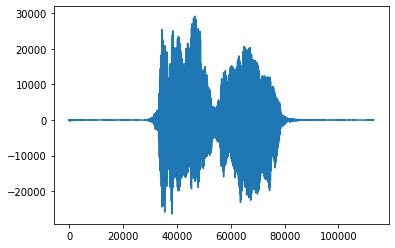

In [27]:
plt.plot(player)

When we zoom in on a 1000 size sample. It can be seen that this sound is composed of a pattern that repeats roughly every 200 samples. This pattern changes form several times throughout the signal it is always the case that waveforms are similar to their neighbors.

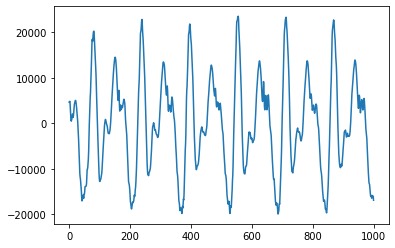

In [28]:
plt.plot(player[40000:41000])

Below is my first attemps at a function that changes the pitch and length independently of eachother. This function takes an array (which can be obtained from a wav file) and the scaling factor (how many times the original length you want the new sample to be). When the output array is converted back into a wav file with the same sampling rate as the original, its pitch is the same as that of the original but its length is that of the original clip times the scaling factor.

In [0]:
def pitchScale(yy, scale):
  
  # This function fits a polynomial to data. It is necessary to smooth the data
  # outliers don't create extra zero crossing points.  
  def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    from math import factorial
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')
  
  # This function identifies the zero crossing points and then creates a nested
  # list of data between those zero crossing points. 
  def zeroChunk(yy):
    xx = np.array(list(range(len(yy))))
    xx = xx.astype(int) 
    #xx = np.linspace(0,len(yy),1)
    data = savitzky_golay(yy, 51, 3)
    #data = yy
    layer = np.vstack((data, xx))
    lay = layer.T
    zero_crossings = np.where(np.diff(np.signbit(layer[0])))[0]
    zero_crossings = zero_crossings + 1
    zeroList = []
    for i in range(len(zero_crossings)-1):
      zeroList.append(np.array(range(zero_crossings[i], zero_crossings[i+1]))) 

    newList = []
    for i in zeroList:
      newList.append(lay[i])
    return newList
  
  # This function compares arrays (element-wise) and totals their differences. 
  # This function is used later by comparing each set of data between 0 crossing
  # points to that of its nieghbors. That comparison is then used to group similar
  # wave forms.
  def compare(arr1, arr2):
    if len(arr1) > len(arr2):
      arr2 = np.append(arr2, np.zeros(len(arr1)-len(arr2)))
    
    total = 0
    for i in range(len(arr1)):
      total = total + np.abs(arr1[i]-arr2[i])
    return(total)
  
  # Once the similar wave forms have been grouped, this function will repeat or
  # delete those similar wave forms at evenly spaced intervals in order to 
  # achive the desired length (the 'length' arguement).
  def augment(arr, length):

    diff = length - len(arr)

    if diff > 0:
      space = len(arr)/ diff
      indF = np.array(range(0, diff)) * space
      ind = indF.astype(int)
      b= np.array(arr)[ind.astype(int)]
      #b= np.array([arr[ind]])
      #b = arr[ind]
      return np.insert(arr,ind,b)

    elif diff < 0:
      absol = - diff
      space = len(arr)/ absol
      indF = np.array(range(0, absol)) * space
      ind = indF.astype(int)
      return np.delete(arr, ind)



  newList = zeroChunk(yy) # Split data into nested list of data b/t zero 
                          # crossing points.  
  
  
  # The following code iterates over the list created above, matching similar 
  # nieghbors, and dividing the wavform into similar chunks.
  chunkList = []
  i= 0
  while i < len(newList) - 5: 
    pra = np.zeros(5)
    for j in range(1,6):
      pra[j-1] = compare(newList[i].T[0], newList[i+j].T[0])
    
    twin = np.argmin(pra)
    chunkList.append(int(newList[i][0][1]))
    i = i + twin + 1
  chunkList.append(int(newList[i][0][1]))
  
  sampleChunks =[]
  for i in range(len(chunkList)):
    if i > 0:
      sampleChunks.append(yy[chunkList[i-1]: chunkList[i]])
  
  # This code used the augment function to change the array to the desired 
  # length and then returns that array.
  ment = augment(sampleChunks, int(len(sampleChunks)*scale))
  final = np.concatenate(ment)
  return (final)
  
  




Below is what the clip sounds like slowed down to half the speed.

In [32]:
double = pitchScale(player, 2)
Audio(double, rate = 44100)

In [0]:
# To write this clip to your working directory as an MP3 file, run this cell.

db16 =np.array(double, dtype = np.int16)
wavfile.write('deleteme.wav', 44100, db16)
AudioSegment.from_wav('deleteme.wav').export('doubleSpeed.mp3', format="mp3")
os.remove("deleteme.wav")


The way the pitchScale function works is by grouping patterns in the wavform. As you can see below this function correctly split this this waveform into similar chuncks. To increase the length, every n chunk is repeated, and to decrease the length every n chunk is deleted. This is done in the 'augment' function. 
![alt text](https://drive.google.com/uc?id=1xLZsASzi7CB_s5ZoW-03y6a5uxKSIvS5)